In [104]:
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
from datetime import datetime, timedelta

## I. Process Stock History Data

In [105]:
# Download Stock History data
# Training data from 2021-01-01 to 2021-05-31
GME_data = yf.Ticker('GME')
GME_train = GME_data.history(start='2021-01-01', end='2021-05-31', interval='1d')
GME_train.reset_index(inplace=True)
GME_train['Date'] = GME_train['Date'].dt.date
GME_train['Close'].fillna(GME_train['Close'].mean(), inplace=True)
GME_train.tail()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
97,2021-05-24,43.962502,47.115002,43.337502,45.002499,18657200,0.0,0.0
98,2021-05-25,45.250000,54.277500,45.250000,52.357498,59550000,0.0,0.0
99,2021-05-26,57.250000,62.119999,56.387501,60.639999,84479600,0.0,0.0
100,2021-05-27,57.450001,66.000000,56.750000,63.532501,62105200,0.0,0.0
101,2021-05-28,65.742500,67.199997,55.357498,55.500000,47005600,0.0,0.0


In [106]:
# Test data fraom 2021-06-01 to 2021-03-31
GME_test = GME_data.history(start='2021-06-01', end='2021-08-31', interval='1d')
GME_test.reset_index(inplace=True)
GME_test['Date'] = GME_test['Date'].dt.date
GME_test['Close'].fillna(GME_test['Close'].mean(), inplace=True)
GME_test.tail()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
59,2021-08-24,41.572498,56.250000,41.287498,52.572498,58608800,0.0,0.0
60,2021-08-25,51.662498,56.750000,48.250000,49.912498,51444400,0.0,0.0
61,2021-08-26,50.169998,54.250000,49.750000,51.305000,24954400,0.0,0.0
62,2021-08-27,51.924999,53.250000,50.005001,51.237499,12923200,0.0,0.0
63,2021-08-30,51.250000,54.547501,50.755001,52.299999,13238400,0.0,0.0


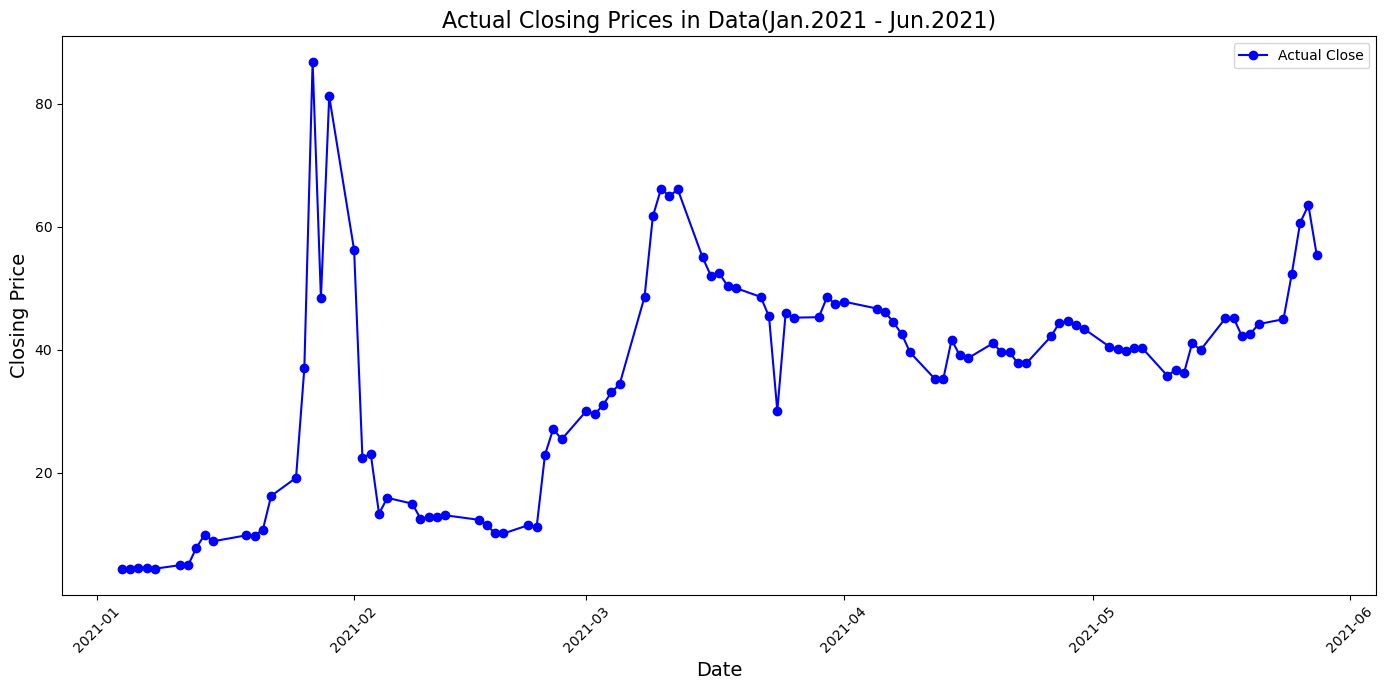

In [107]:
# Visualizating Closing Prices in the training dataset
# Ensure the 'Date' column is in datetime format for proper plotting
GME_train['Date'] = pd.to_datetime(GME_train['Date'])

# Setting the plot size for better readability
plt.figure(figsize=(14, 7))

# Plotting the actual closing prices in the training period
plt.plot(GME_train['Date'], GME_train['Close'], label='Actual Close', color='blue', marker='o')

# Adding title and labels with font size adjustments
plt.title('Actual Closing Prices in Data(Jan.2021 - Jun.2021)', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Closing Price', fontsize=14)

# Rotating date labels for better visibility
plt.xticks(rotation=45)

# Adding a legend to distinguish the actual values
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()

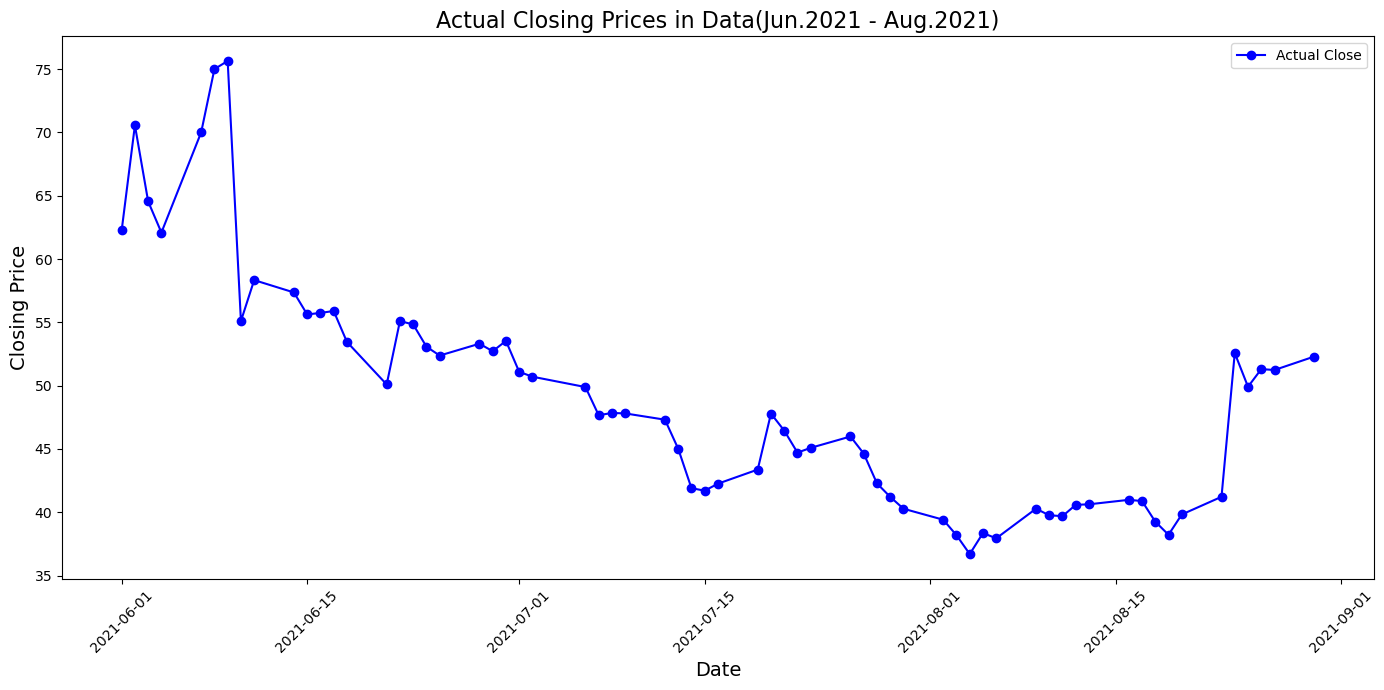

In [108]:
# Visualizating Closing Prices in the training dataset
# Ensure the 'Date' column is in datetime format for proper plotting
GME_test['Date'] = pd.to_datetime(GME_test['Date'])

# Setting the plot size for better readability
plt.figure(figsize=(14, 7))

# Plotting the actual closing prices in the training period
plt.plot(GME_test['Date'], GME_test['Close'], label='Actual Close', color='blue', marker='o')

# Adding title and labels with font size adjustments
plt.title('Actual Closing Prices in Data(Jun.2021 - Aug.2021)', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Closing Price', fontsize=14)

# Rotating date labels for better visibility
plt.xticks(rotation=45)

# Adding a legend to distinguish the actual values
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()

## Pre-processing stock data for Time Series Analysis

In [109]:
# Convert 'Date' to datetime and sort the DataFrame just in case
GME_train['Date'] = pd.to_datetime(GME_train['Date'])
GME_train.sort_values('Date', inplace=True)
#  The .values attribute returns the data as a NumPy array. The .reshape(-1, 1) function changes
#  the shape of this array to ensure it has two dimensions, with one column and as many rows as necessary.
close_prices = GME_train['Close'].values.reshape(-1, 1)

# # Scale the data -> you can use any appropriate scaling methodology
# scaler = MinMaxScaler(feature_range=(0, 1))
scaler = MaxAbsScaler()
scaled_close_prices = scaler.fit_transform(close_prices)


In [110]:
# Function to create sequences
def create_sequences(data, sequence_length):
    xs, ys = [], []
    for i in range(len(data) - sequence_length):
        x = data[i:(i + sequence_length)]
        y = data[i + sequence_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

In [111]:
SEQUENCE_LENGTH = 13  # You can adjust this value -> parameter tuning
X_train, y_train = create_sequences(scaled_close_prices, SEQUENCE_LENGTH)

## Train LSTM

In [121]:
# Initialize the LSTM model, four LSTM layers and one Dense layer at the end
regressor = Sequential()
regressor.add(LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressor.add(LSTM(units=80, return_sequences=True))
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(LSTM(units=30))
regressor.add(Dense(units=1))
regressor.compile(optimizer='adam',loss='mean_squared_error')

In [122]:
# Fit the LSTM on training dataset
regressor.fit(X_train, y_train, epochs=100, batch_size=32)

Epoch 1/100
3/3 [==============================] - 2s 13ms/step - loss: 0.1908
Epoch 2/100
3/3 [==============================] - 0s 10ms/step - loss: 0.0761
Epoch 3/100
3/3 [==============================] - 0s 11ms/step - loss: 0.0608
Epoch 4/100
3/3 [==============================] - 0s 12ms/step - loss: 0.0466
Epoch 5/100
3/3 [==============================] - 0s 12ms/step - loss: 0.0410
Epoch 6/100
3/3 [==============================] - 0s 11ms/step - loss: 0.0437
Epoch 7/100
3/3 [==============================] - 0s 12ms/step - loss: 0.0393
Epoch 8/100
3/3 [==============================] - 0s 13ms/step - loss: 0.0341
Epoch 9/100
3/3 [==============================] - 0s 11ms/step - loss: 0.0355
Epoch 10/100
3/3 [==============================] - 0s 12ms/step - loss: 0.0351
Epoch 11/100
3/3 [==============================] - 0s 11ms/step - loss: 0.0338
Epoch 12/100
3/3 [==============================] - 0s 11ms/step - loss: 0.0341
Epoch 13/100
3/3 [==============================]

## Making predictions on Test Data

In [123]:
business_days = pd.date_range(start=pd.to_datetime('2021-05-31') + timedelta(days=1),
                              periods=66, freq='B')
business_days

DatetimeIndex(['2021-06-01', '2021-06-02', '2021-06-03', '2021-06-04',
               '2021-06-07', '2021-06-08', '2021-06-09', '2021-06-10',
               '2021-06-11', '2021-06-14', '2021-06-15', '2021-06-16',
               '2021-06-17', '2021-06-18', '2021-06-21', '2021-06-22',
               '2021-06-23', '2021-06-24', '2021-06-25', '2021-06-28',
               '2021-06-29', '2021-06-30', '2021-07-01', '2021-07-02',
               '2021-07-05', '2021-07-06', '2021-07-07', '2021-07-08',
               '2021-07-09', '2021-07-12', '2021-07-13', '2021-07-14',
               '2021-07-15', '2021-07-16', '2021-07-19', '2021-07-20',
               '2021-07-21', '2021-07-22', '2021-07-23', '2021-07-26',
               '2021-07-27', '2021-07-28', '2021-07-29', '2021-07-30',
               '2021-08-02', '2021-08-03', '2021-08-04', '2021-08-05',
               '2021-08-06', '2021-08-09', '2021-08-10', '2021-08-11',
               '2021-08-12', '2021-08-13', '2021-08-16', '2021-08-17',
      

In [124]:
# Get the last sequence from the training data
last_sequence = X_train[-1].reshape((1, SEQUENCE_LENGTH, 1))

In [125]:
# Create a list to hold predictions
predictions = []

# Predict future prices
for i in range(len(business_days)):
    # Get the prediction (scaled value)
    current_prediction = regressor.predict(last_sequence)[0]

    # Append the prediction
    predictions.append(current_prediction)

    # Update the sequence
    last_sequence = np.roll(last_sequence, -1, axis=1)
    last_sequence[0, -1, 0] = current_prediction

# Inverse transform the predictions to get actual values
predicted_prices = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

# Create a DataFrame with the predicted stock prices and dates
predictions_df = pd.DataFrame({
    'Date': business_days,
    'Predicted_Close': predicted_prices.flatten()
})

# Show the prediction results
print(predictions_df)

1/1 [==============================] - 0s 7ms/step
         Date  Predicted_Close
0  2021-06-01        49.810452
1  2021-06-02        51.268406
2  2021-06-03        51.181324
3  2021-06-04        49.926693
4  2021-06-07        48.465530
..        ...              ...
61 2021-08-25        44.156693
62 2021-08-26        44.155075
63 2021-08-27        44.153606
64 2021-08-30        44.152260
65 2021-08-31        44.151028

[66 rows x 2 columns]


In [126]:
# Continue from the previous predictions_df creation code

# Ensure the 'Date' columns in both DataFrames are in the same format
GME_test['Date'] = pd.to_datetime(GME_test['Date'])
predictions_df['Date'] = pd.to_datetime(predictions_df['Date'])

# Merge the predictions with the actual closing prices from 'df'
predictions_with_actuals_df = predictions_df.merge(GME_test[['Date', 'Close']], on='Date', how='inner')

# Rename columns for clarity
predictions_with_actuals_df.rename(columns={'Close': 'Actual_Close'}, inplace=True)

# Show the DataFrame with predictions and actual closing prices
print(predictions_with_actuals_df)

         Date  Predicted_Close  Actual_Close
0  2021-06-01        49.810452     62.255001
1  2021-06-02        51.268406     70.559998
2  2021-06-03        51.181324     64.544998
3  2021-06-04        49.926693     62.090000
4  2021-06-07        48.465530     70.002502
..        ...              ...           ...
59 2021-08-24        44.158474     52.572498
60 2021-08-25        44.156693     49.912498
61 2021-08-26        44.155075     51.305000
62 2021-08-27        44.153606     51.237499
63 2021-08-30        44.152260     52.299999

[64 rows x 3 columns]


In [127]:
predictions_with_actuals_df

,Date,Predicted_Close,Actual_Close
0,2021-06-01,49.810452,62.255001
1,2021-06-02,51.268406,70.559998
2,2021-06-03,51.181324,64.544998
3,2021-06-04,49.926693,62.090000
4,2021-06-07,48.465530,70.002502
...,...,...,...
59,2021-08-24,44.158474,52.572498
60,2021-08-25,44.156693,49.912498
61,2021-08-26,44.155075,51.305000
62,2021-08-27,44.153606,51.237499


## Visualization of Prediction vs. Actual (without sentiment analysis)

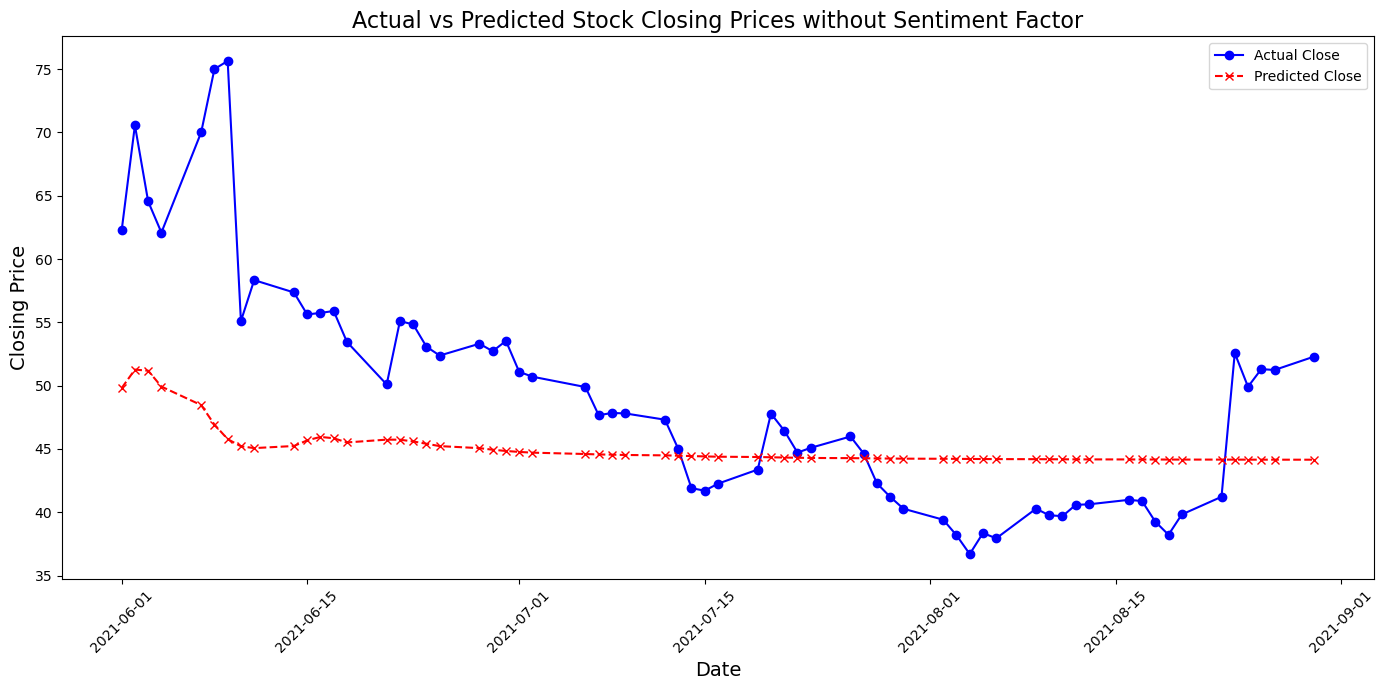

In [128]:
# Ensure the 'Date' column is in datetime format for proper plotting
predictions_with_actuals_df['Date'] = pd.to_datetime(predictions_with_actuals_df['Date'])

# Setting the plot size for better readability
plt.figure(figsize=(14, 7))

# Plotting the actual closing prices
plt.plot(predictions_with_actuals_df['Date'], predictions_with_actuals_df['Actual_Close'], label='Actual Close', color='blue', marker='o')

# Plotting the predicted closing prices
plt.plot(predictions_with_actuals_df['Date'], predictions_with_actuals_df['Predicted_Close'], label='Predicted Close', color='red', linestyle='--', marker='x')

# Adding title and labels with font size adjustments
plt.title('Actual vs Predicted Stock Closing Prices without Sentiment Factor', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Closing Price', fontsize=14)

# Rotating date labels for better visibility
plt.xticks(rotation=45)

# Adding a legend to distinguish between actual and predicted values
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()

In [129]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Extract the actual and predicted values
actual_values = predictions_with_actuals_df['Actual_Close'].values
predicted_values = predictions_with_actuals_df['Predicted_Close'].values

# Calculate MSE
mse = mean_squared_error(actual_values, predicted_values)

# Calculate RMSE
rmse = np.sqrt(mse)

# Calculate MAE
mae = mean_absolute_error(actual_values, predicted_values)

# Print the results
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")


Mean Squared Error (MSE): 80.37133160328221
Root Mean Squared Error (RMSE): 8.965005945524085
Mean Absolute Error (MAE): 6.88510000705719


## II. Process Sentiment Analysis Data

In [18]:
# Initialize Sentiment Score for positive, neutral, and negative sentiment
positive_number = 1
neutral_number = 2
negative_number = 3

## Calculate sentiment Score using VADER: Reddit WallStreetBets Posts

In [19]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/Users/hoshi/Desktop/LLMs/Individual Assignment"

!kaggle datasets download -d gpreda/reddit-wallstreetsbets-posts

reddit-wallstreetsbets-posts.zip: Skipping, found more recently modified local copy (use --force to force download)


In [20]:
import zipfile
import os

# Specify the path to your zip file
zip_path = '/Users/hoshi/Desktop/LLMs/Individual Assignment/reddit-wallstreetsbets-posts.zip'
# Specify the directory to extract the contents to
extract_to = '/Users/hoshi/Desktop/LLMs/Individual Assignment/'

# Create a ZipFile object
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    # Extract all the contents into the directory
    zip_ref.extractall(extract_to)

print(f"Extracted all contents to {os.path.abspath(extract_to)}")

Extracted all contents to /Users/hoshi/Desktop/LLMs/Individual Assignment


In [21]:
# Combine the 'body' of the posts and the 'title' of the posts into one variable 'paragraph'
Reddit_WallStreetBets_Posts = pd.read_csv('reddit_wsb.csv')
Reddit_WallStreetBets_Posts['timestamp'] = pd.to_datetime(Reddit_WallStreetBets_Posts['timestamp']).dt.strftime('%Y-%m-%d')

RWP = Reddit_WallStreetBets_Posts[['title','body','timestamp']].copy()
RWP['body'] = RWP['body'].fillna('')
RWP['title'] = RWP['title'].fillna('')
RWP['paragraph'] = RWP['title'] + ". " + RWP['body']
# Replace NAs with empty String to avoid adding NAs to strings
RWP = RWP[~((RWP['title'] == '') & (RWP['body'] == ''))]
RWP.drop(['title', 'body'], axis=1, inplace=True)
RWP.head()

,timestamp,paragraph
0,2021-01-28,"It's not about the money, it's about sending a..."
1,2021-01-28,Math Professor Scott Steiner says the numbers ...
2,2021-01-28,Exit the system. The CEO of NASDAQ pushed to h...
3,2021-01-28,NEW SEC FILING FOR GME! CAN SOMEONE LESS RETAR...
4,2021-01-28,"Not to distract from GME, just thought our AMC..."


In [22]:
# import SentimentIntensityAnalyzer class
# from vaderSentiment.vaderSentiment module.
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# function to print sentiments of the sentence.
def sentiment_scores(data):

    # Create a SentimentIntensityAnalyzer object.
    sid_obj = SentimentIntensityAnalyzer()

    # polarity_scores method of SentimentIntensityAnalyzer
    # object gives a sentiment dictionary.
    # which contains pos, neg, neu, and compound scores.
    sentiment=[]
    for sentence in data:
        sentiment_dict = sid_obj.polarity_scores(sentence)
        
#         print("\n","Sentence is:", sentence)
#         print("Overall sentiment dictionary is : ", sentiment_dict)
#         print("sentence was rated as ", sentiment_dict['neg']*100, "% Negative")
#         print("sentence was rated as ", sentiment_dict['neu']*100, "% Neutral")
#         print("sentence was rated as ", sentiment_dict['pos']*100, "% Positive")

        # decide sentiment as positive, negative and neutral
        if sentiment_dict['compound'] >= 0.05 :
#             print("positive")
            sentiment.append(positive_number)

        elif sentiment_dict['compound'] <= - 0.05 :
#             print("negative")
            sentiment.append(negative_number)
        else :
#             print("neutral")
            sentiment.append(neutral_number)
    return sentiment

In [23]:
# Calculate Sentiment for RWP paragraph
sentiment = sentiment_scores(RWP['paragraph'])

In [24]:
# Combine the sentiment variable with the RWP dataset
RWP['sentiment']=sentiment
RWP.tail()

,timestamp,paragraph,sentiment
53182,2021-08-02,What I Learned Investigating SAVA FUD Spreader...,3
53183,2021-08-02,"Daily Popular Tickers Thread for August 02, 20...",1
53184,2021-08-02,Hitler reacts to the market being irrational.,3
53185,2021-08-02,"Daily Discussion Thread for August 02, 2021. Y...",1
53186,2021-08-02,Fraternal Association of Gambling Gentlemen an...,2


In [25]:
# Check the distribution of sentiment score in the dataset: 1 = positive, 3 = negative, 2= neutral
from collections import Counter
freq = Counter(sentiment)
freq

Counter({1: 25666, 3: 13795, 2: 13726})

## Sentiment Given: Reddit Dataset on Meme Stock: GameStop

In [26]:
# Read in dataset
Reddit_Meme_Stock= pd.read_csv('rGME_dataset_features.csv',index_col=0)

/var/folders/xk/_r4sdmz94tdddjfh7p0wll_40000gn/T/ipykernel_87992/232028513.py:2: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  Reddit_Meme_Stock= pd.read_csv('rGME_dataset_features.csv',index_col=0)


In [27]:
# Use the existing VADER score in the dataset
RMS_VADER = Reddit_Meme_Stock[['title','date','score']].copy().dropna()
sentiment_mapping = {3: negative_number, 2: neutral_number, 1: positive_number}
RMS_VADER['sentiment'] = RMS_VADER['score'].map(sentiment_mapping)

In [28]:
# # Alternate approach I: 
# # Keep the columns that records pos, neg, and neu probabilities generated from SpaCy large English model
# Reddit_Meme_Stock['date'] = pd.to_datetime(Reddit_Meme_Stock['date']).dt.strftime('%Y-%m-%d')
# RMS = Reddit_Meme_Stock[['title','date','neg','neu','pos']].copy().dropna()
# # Set the Sentiment as the one with the highest probability
# RMS['sentiment'] = RMS[['neg', 'neu', 'pos']].idxmax(axis=1)
# # Set sentiment score to be the values decided ealier
# sentiment_mapping = {'neg': negative_number, 'neu': neutral_number, 'pos': positive_number}
# RMS['sentiment'] = RMS['sentiment'].map(sentiment_mapping)
# RMS.drop(['neg','neu','pos'], axis=1, inplace=True)
# RMS.head()

In [29]:
# # Alternative II:
# # using 'compound'

# Reddit_Meme_Stock['date'] = pd.to_datetime(Reddit_Meme_Stock['date']).dt.strftime('%Y-%m-%d')
# RMS = Reddit_Meme_Stock[['title','date','compound']].copy().dropna()
# RMS['sentiment'] = RMS['compound'].apply(lambda x: positive_number if x > 0.05 
#                                          else negative_number if x < -0.05 
#                                          else neutral_number)
# RMS.drop('compound', axis=1, inplace=True)
# RMS.head()

In [30]:
# sum(RMS['sentiment'] == positive_number)

In [31]:
# sum(RMS['sentiment'] == neutral_number)

In [32]:
# sum(RMS['sentiment'] == negative_number)

In [33]:
RMS_VADER.shape

(1033236, 4)

In [34]:
RMS_VADER.head()

,title,date,score,sentiment
0,You NEED to see this about GME 🚀🚀🚀🚀🚀🚀,2021-01-04,1.0,1.0
1,Short Squeeze Incoming 🚀🚀🚀🚀🚀🚀🚀,2021-01-04,1.0,1.0
2,THIS CONVINCED ME TO ALL IN 💰GME (EXTREME PUMP...,2021-01-05,1.0,1.0
3,You already know what we must do brothers and ...,2021-01-05,1.0,1.0
4,ICR conference (11th Jan),2021-01-06,1.0,1.0


In [35]:
sum(RMS_VADER['sentiment'] == positive_number)

957936

In [36]:
sum(RMS_VADER['sentiment'] == neutral_number)

21955

In [37]:
sum(RMS_VADER['sentiment'] == negative_number)

6184

## Sentiment Analysis Dataset Aggregation

In [38]:
# Combine two sentiment datasets with only sentiment from each day
combined_sentiment = pd.concat([RWP[['timestamp', 'sentiment']], RMS_VADER[['date', 'sentiment']].rename(columns={'date': 'timestamp'})])
combined_sentiment

,timestamp,sentiment
0,2021-01-28,2.0
1,2021-01-28,3.0
2,2021-01-28,3.0
3,2021-01-28,3.0
4,2021-01-28,1.0
...,...,...
1033231,2021-12-31,1.0
1033232,2021-12-31,1.0
1033233,2021-12-31,1.0
1033234,2021-12-31,1.0


In [39]:
#The sentiment scores are 1.0 for positive, 2.0 for neutral, and 3.0 for negative

# Step 1: Ensure 'timestamp' is a datetime object
combined_sentiment['timestamp'] = pd.to_datetime(combined_sentiment['timestamp'])

# Step 2: Convert 'sentiment' scores to dummy variables
sentiment_dummies = pd.get_dummies(combined_sentiment['sentiment'])

# Step 3: Group by 'timestamp' and sum the dummies to get the count per day
# We'll have one column for each sentiment score (1.0, 2.0, 3.0)
daily_sentiment_counts = sentiment_dummies.groupby(combined_sentiment['timestamp']).sum()

# Step 4: Rename the columns based on your requirement
daily_sentiment_counts.columns = ['positive', 'neutral', 'negative']

daily_sentiment_counts.reset_index(inplace=True)

In [40]:
daily_sentiment_counts

,timestamp,positive,neutral,negative
0,2020-09-29,1,0,0
1,2021-01-04,2,0,0
2,2021-01-05,2,0,0
3,2021-01-06,2,0,0
4,2021-01-10,1,0,0
...,...,...,...,...
355,2021-12-27,127,3,0
356,2021-12-28,185,1,0
357,2021-12-29,187,0,0
358,2021-12-30,176,4,0


In [41]:
# Take the average of all the sentiment in one day as the sentiment score for that day
average_sentiment_per_day = combined_sentiment.groupby('timestamp')['sentiment'].mean().reset_index()
#average_sentiment_per_day

/var/folders/xk/_r4sdmz94tdddjfh7p0wll_40000gn/T/ipykernel_87992/342766213.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_average_sentiment.sort_values('timestamp', inplace=True)


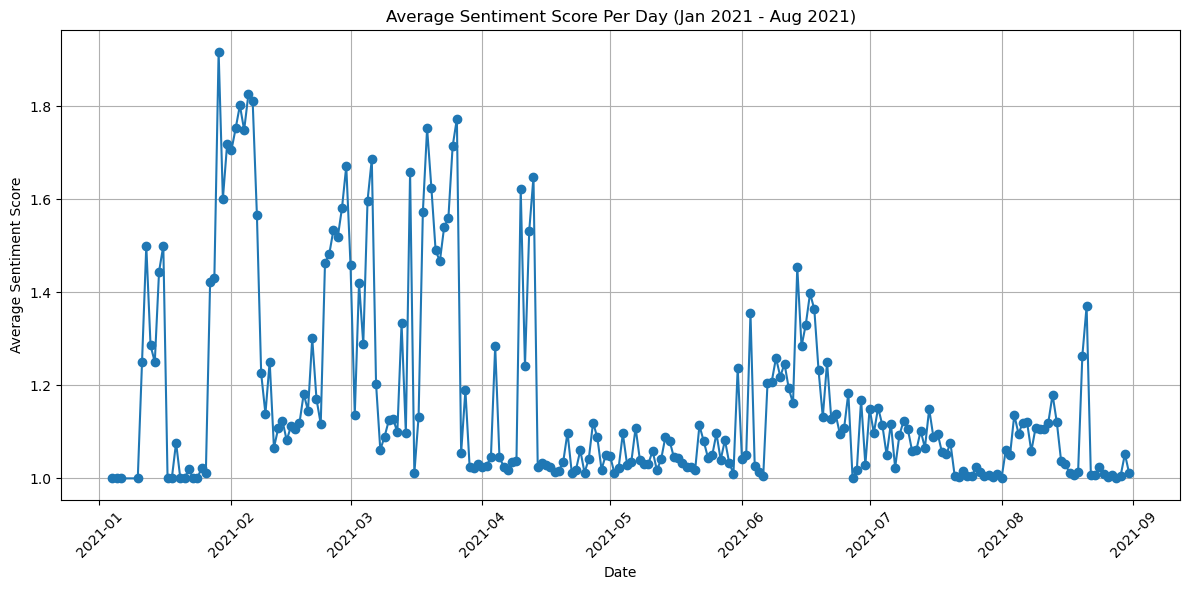

In [42]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure your 'timestamp' column is in datetime format for proper plotting
average_sentiment_per_day['timestamp'] = pd.to_datetime(average_sentiment_per_day['timestamp'])

# Define start and end dates for the period you want to plot
start_date = '2021-01-04'
end_date = '2021-08-31'


# Filter the DataFrame for the date range
mask = (average_sentiment_per_day['timestamp'] >= start_date) & (average_sentiment_per_day['timestamp'] <= end_date)
filtered_average_sentiment = average_sentiment_per_day.loc[mask]

# Sort the filtered DataFrame by 'timestamp'
filtered_average_sentiment.sort_values('timestamp', inplace=True)

# Plotting the line graph for the filtered date range
plt.figure(figsize=(12, 6))  # Set the figure size as needed
plt.plot(filtered_average_sentiment['timestamp'], filtered_average_sentiment['sentiment'], marker='o')
plt.title('Average Sentiment Score Per Day (Jan 2021 - Aug 2021)')  # Set title
plt.xlabel('Date')  # Set x-axis label
plt.ylabel('Average Sentiment Score')  # Set y-axis label
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to fit all labels
plt.grid(True)  # Add grid for easier reading

plt.show()  # Display the plot


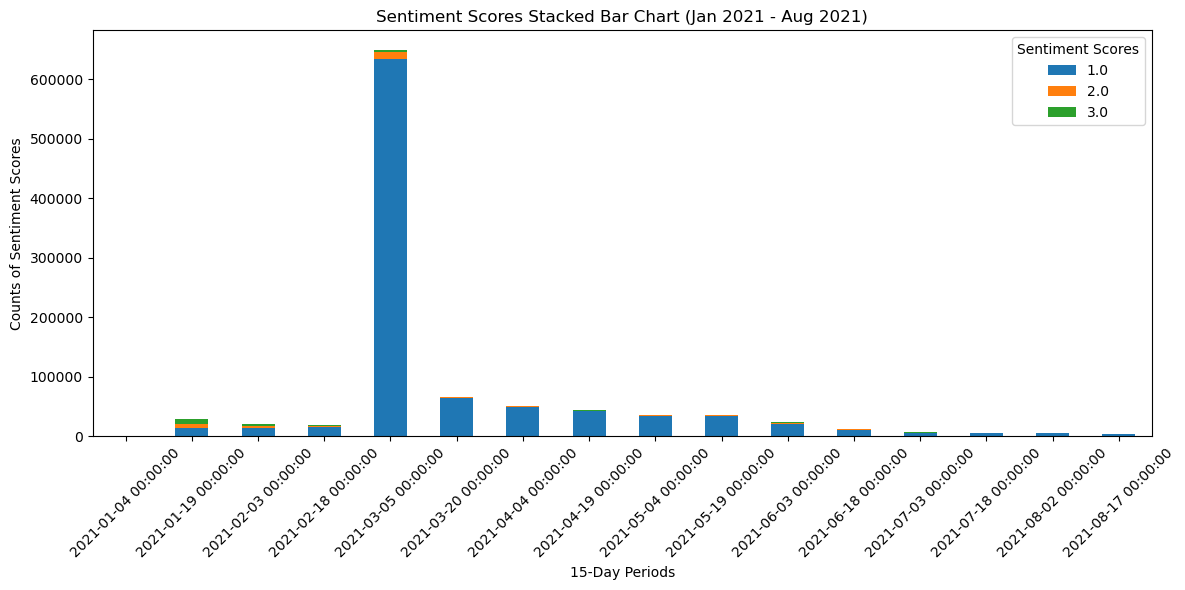

In [43]:
# Assuming 'combined_sentiment' has 'timestamp' or 'date' as the index
combined_sentiment['timestamp'] = pd.to_datetime(combined_sentiment['timestamp'])
combined_sentiment.set_index('timestamp', inplace=True)

# Filter the DataFrame for the desired date range
start_date = '2021-01-04'
end_date = '2021-08-31'
filtered_data = combined_sentiment.loc[start_date:end_date]

# Resample to 15-day periods and count the sentiment scores
# The sentiment_score column should be categorical with values like 'positive', 'negative', 'neutral'
# If it's numerical, ensure it represents distinct categories that can be stacked
resampled_data = filtered_data.resample('15D')['sentiment'].value_counts().unstack().fillna(0)

# Plotting
resampled_data.plot(kind='bar', stacked=True, figsize=(12, 6))

plt.title('Sentiment Scores Stacked Bar Chart (Jan 2021 - Aug 2021)')
plt.xlabel('15-Day Periods')
plt.ylabel('Counts of Sentiment Scores')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend(title='Sentiment Scores')
plt.tight_layout()  # Adjust layout to fit all labels
plt.show()


## III. Model Fusion
## Combine Sentiment Dataset with Stock price Dataset

In [130]:
# Ensure the 'timestamp' column in 'average_sentiment_per_day' and 'Date' column in 'GME_train' are datetime
average_sentiment_per_day['timestamp'] = pd.to_datetime(average_sentiment_per_day['timestamp'])
GME_train['Date'] = pd.to_datetime(GME_train['Date'])

# Merge the DataFrames on the date columns, keeping only the dates from 'GME_train' (left join)
GME_Sentiment = pd.merge(GME_train, average_sentiment_per_day, left_on='Date', right_on='timestamp', how='left')

# Drop the 'timestamp' column as it's redundant with 'Date' after the merge
GME_Sentiment.drop('timestamp', axis=1, inplace=True)

# Replace NaN sentiment scores with 0 or an appropriate value
# (assuming that no sentiment data means neutral sentiment for that day)
GME_Sentiment['sentiment'].fillna(neutral_number, inplace=True)

# Now you have 'combined_data' DataFrame with stock prices and the corresponding average sentiment score
print(GME_Sentiment.head())

        Date    Open    High     Low   Close    Volume  Dividends  \
0 2021-01-04  4.7500  4.7750  4.2875  4.3125  40090000        0.0   
1 2021-01-05  4.3375  4.5200  4.3075  4.3425  19846000        0.0   
2 2021-01-06  4.3350  4.7450  4.3325  4.5900  24224800        0.0   
3 2021-01-07  4.6175  4.8625  4.5050  4.5200  24517200        0.0   
4 2021-01-08  4.5450  4.5750  4.2700  4.4225  25928000        0.0   

   Stock Splits  sentiment  
0           0.0        1.0  
1           0.0        1.0  
2           0.0        1.0  
3           0.0        2.0  
4           0.0        2.0  


In [131]:
GME_Sentiment['Date'] = pd.to_datetime(GME_Sentiment['Date'])
GME_Sentiment.sort_values('Date', inplace=True)

# Combine 'Close' prices and 'sentiment' scores into a single matrix
features = GME_Sentiment[['Close', 'sentiment']].values

# Scale the features, can use alternative ways to scale the dataset
# scaler = MinMaxScaler(feature_range=(0, 1))
scaler = MaxAbsScaler()
scaled_features = scaler.fit_transform(features)

In [132]:
X_train, y_train = create_sequences(scaled_features, SEQUENCE_LENGTH)

In [133]:
# Initialize the LSTM model
regressor = Sequential()
# First LSTM layer with Dropout regularisation
regressor.add(LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
#regressor.add(Dropout(0.3))

regressor.add(LSTM(units=80, return_sequences=True))
#regressor.add(Dropout(0.1))

regressor.add(LSTM(units=50, return_sequences=True))
#regressor.add(Dropout(0.2))

regressor.add(LSTM(units=30))
#regressor.add(Dropout(0.3))

# Final Dense layer to output the predicted closing price
regressor.add(Dense(units=1))

# Compile the model
regressor.compile(optimizer='adam', loss='mean_squared_error')


In [134]:
# Train LSTM on traifcrning dataset
regressor.fit(X_train, y_train, epochs=100, batch_size=32)

Epoch 1/100
3/3 [==============================] - 2s 13ms/step - loss: 0.2654
Epoch 2/100
3/3 [==============================] - 0s 10ms/step - loss: 0.1052
Epoch 3/100
3/3 [==============================] - 0s 11ms/step - loss: 0.0517
Epoch 4/100
3/3 [==============================] - 0s 12ms/step - loss: 0.0525
Epoch 5/100
3/3 [==============================] - 0s 11ms/step - loss: 0.0374
Epoch 6/100
3/3 [==============================] - 0s 11ms/step - loss: 0.0462
Epoch 7/100
3/3 [==============================] - 0s 12ms/step - loss: 0.0394
Epoch 8/100
3/3 [==============================] - 0s 12ms/step - loss: 0.0333
Epoch 9/100
3/3 [==============================] - 0s 12ms/step - loss: 0.0373
Epoch 10/100
3/3 [==============================] - 0s 12ms/step - loss: 0.0360
Epoch 11/100
3/3 [==============================] - 0s 11ms/step - loss: 0.0328
Epoch 12/100
3/3 [==============================] - 0s 11ms/step - loss: 0.0339
Epoch 13/100
3/3 [==============================]

## Predict on Test Dataset

In [135]:
GME_Sentiment['Date'] = pd.to_datetime(GME_Sentiment['Date'])

sentiment_scores = GME_Sentiment['sentiment'].values[-SEQUENCE_LENGTH:].tolist()

business_days = pd.date_range(start=GME_Sentiment['Date'].iloc[-1] + timedelta(days=1),
                              periods=66, freq='B')

In [136]:
# business_days = pd.date_range(start=pd.to_datetime('2021-01-01') + timedelta(days=1),
#                               periods=105, freq='B')
# # Get the last sequence from the training data
# last_sequence = scaled_features[-SEQUENCE_LENGTH:].reshape((1, SEQUENCE_LENGTH, 2))

# # Create a list to hold predictions
# predictions = []

# # Predict future prices using both stock price and sentiment score
# for i in range(len(business_days)):
#     # Get the prediction (scaled value)
#     current_prediction = regressor.predict(last_sequence)[0]

#     # Append the predicted price only
#     predictions.append(current_prediction[0])

#     # Update the sequence with the new prediction and the forward-filled sentiment score
#     new_row = [current_prediction[0], sentiment_scores[-1]]  # The last known sentiment score
#     last_sequence = np.roll(last_sequence, -1, axis=1)
#     last_sequence[0, -1, :] = new_row
    
# # Create an array of zeros for the sentiment scores
# dummy_sentiment_scores = np.zeros((len(predictions), 1))

# # Stack the predictions with the dummy sentiment scores
# predicted_features = np.hstack((np.array(predictions).reshape(-1, 1), dummy_sentiment_scores))

# # Now use the scaler to inverse transform the predicted features
# predicted_prices = scaler.inverse_transform(predicted_features)[:, 0]  # Select only the prices


# # Inverse transform the predictions to get actual values
# #predicted_prices = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

# # Create a DataFrame with the predicted stock prices and dates
# predictions_df = pd.DataFrame({
#     'Date': business_days,
#     'Predicted_Close': predicted_prices.flatten()
# })


# # Continue from the previous predictions_df creation code
# # Ensure the 'Date' columns in both DataFrames are in the same format
# GME_train['Date'] = pd.to_datetime(GME_train['Date'])
# predictions_df['Date'] = pd.to_datetime(predictions_df['Date'])

# # Merge the predictions with the actual closing prices from 'df'
# predictions_with_actuals_df = predictions_df.merge(GME_train[['Date', 'Close']], on='Date', how='inner')

# # Rename columns for clarity
# predictions_with_actuals_df.rename(columns={'Close': 'Actual_Close'}, inplace=True)

# # Show the DataFrame with predictions and actual closing prices
# print(predictions_with_actuals_df)


# # Ensure the 'Date' column is in datetime format for proper plotting
# predictions_with_actuals_df['Date'] = pd.to_datetime(predictions_with_actuals_df['Date'])

# # Setting the plot size for better readability
# plt.figure(figsize=(14, 7))

# # Plotting the actual closing prices
# plt.plot(predictions_with_actuals_df['Date'], predictions_with_actuals_df['Actual_Close'], label='Actual Close', color='blue', marker='o')

# # Plotting the predicted closing prices
# plt.plot(predictions_with_actuals_df['Date'], predictions_with_actuals_df['Predicted_Close'], label='Predicted Close', color='red', linestyle='--', marker='x')

# # Adding title and labels with font size adjustments
# plt.title('Actual vs Predicted Stock Closing Prices WITH sentiment score', fontsize=16)
# plt.xlabel('Date', fontsize=14)
# plt.ylabel('Closing Price', fontsize=14)

# # Rotating date labels for better visibility
# plt.xticks(rotation=45)

# # Adding a legend to distinguish between actual and predicted values
# plt.legend()

# # Display the plot
# plt.tight_layout()
# plt.show()

In [137]:
# Get the last sequence from the training data
last_sequence = scaled_features[-SEQUENCE_LENGTH:].reshape((1, SEQUENCE_LENGTH, 2))

# Create a list to hold predictions
predictions = []

# Predict future prices using both stock price and sentiment score
for i in range(len(business_days)):
    # Get the prediction (scaled value)
    current_prediction = regressor.predict(last_sequence)[0]

    # Append the predicted price only
    predictions.append(current_prediction[0])

    # Update the sequence with the new prediction and the forward-filled sentiment score
    new_row = [current_prediction[0], sentiment_scores[-1]]  # The last known sentiment score
    last_sequence = np.roll(last_sequence, -1, axis=1)
    last_sequence[0, -1, :] = new_row
    
# Create an array of zeros for the sentiment scores
dummy_sentiment_scores = np.zeros((len(predictions), 1))

# Stack the predictions with the dummy sentiment scores
predicted_features = np.hstack((np.array(predictions).reshape(-1, 1), dummy_sentiment_scores))

# Now use the scaler to inverse transform the predicted features
predicted_prices = scaler.inverse_transform(predicted_features)[:, 0]  # Select only the prices


# Inverse transform the predictions to get actual values
#predicted_prices = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

# Create a DataFrame with the predicted stock prices and dates
predictions_df = pd.DataFrame({
    'Date': business_days,
    'Predicted_Close': predicted_prices.flatten()
})

1/1 [==============================] - 0s 8ms/step


In [138]:
# Continue from the previous predictions_df creation code
# Ensure the 'Date' columns in both DataFrames are in the same format
GME_test['Date'] = pd.to_datetime(GME_test['Date'])
predictions_df['Date'] = pd.to_datetime(predictions_df['Date'])

# Merge the predictions with the actual closing prices from 'df'
predictions_with_actuals_df = predictions_df.merge(GME_test[['Date', 'Close']], on='Date', how='inner')

# Rename columns for clarity
predictions_with_actuals_df.rename(columns={'Close': 'Actual_Close'}, inplace=True)

# Show the DataFrame with predictions and actual closing prices
predictions_with_actuals_df

         Date  Predicted_Close  Actual_Close
0  2021-06-01        48.807445     62.255001
1  2021-06-02        49.415652     70.559998
2  2021-06-03        49.513170     64.544998
3  2021-06-04        49.233634     62.090000
4  2021-06-07        48.358657     70.002502
..        ...              ...           ...
59 2021-08-24        40.387713     52.572498
60 2021-08-25        40.402958     49.912498
61 2021-08-26        40.390978     51.305000
62 2021-08-27        40.357016     51.237499
63 2021-08-30        40.307271     52.299999

[64 rows x 3 columns]


In [158]:
predictions_with_actuals_df

,Date,Predicted_Close,Actual_Close
0,2021-06-01,48.807445,62.255001
1,2021-06-02,49.415652,70.559998
2,2021-06-03,49.513170,64.544998
3,2021-06-04,49.233634,62.090000
4,2021-06-07,48.358657,70.002502
...,...,...,...
59,2021-08-24,40.387713,52.572498
60,2021-08-25,40.402958,49.912498
61,2021-08-26,40.390978,51.305000
62,2021-08-27,40.357016,51.237499


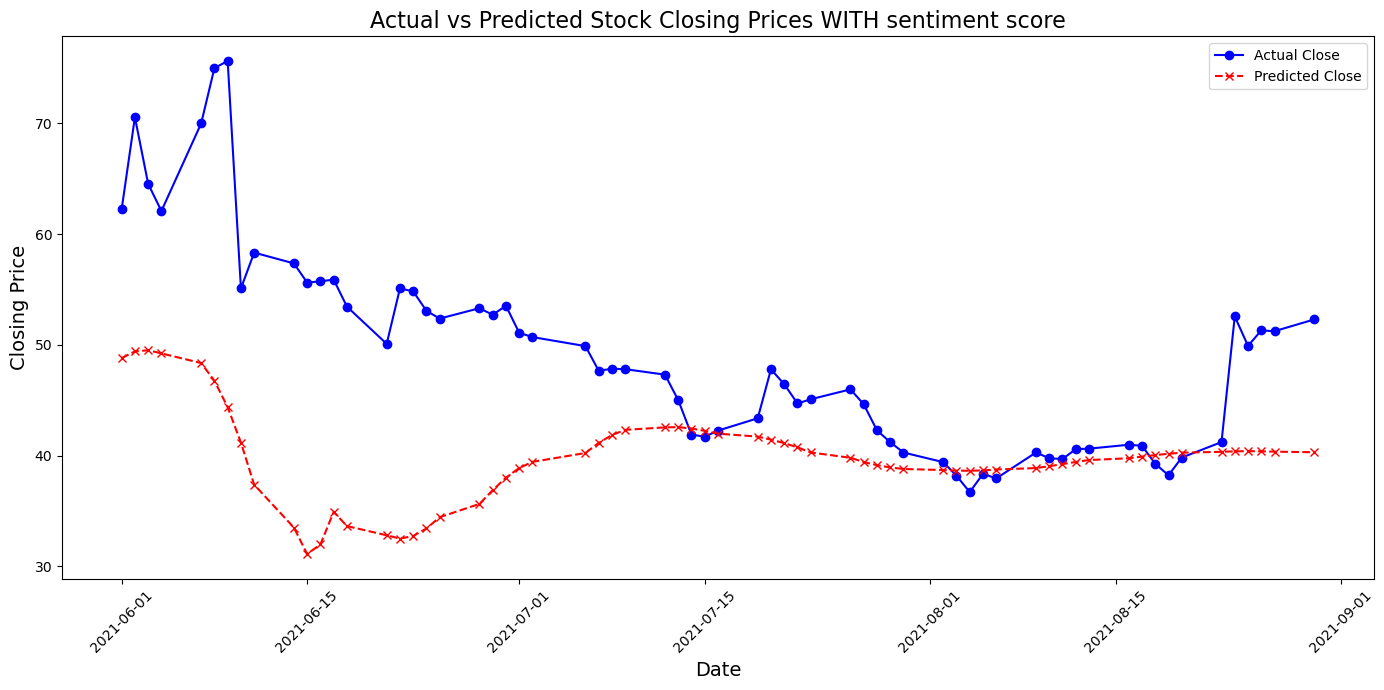

In [139]:
# Ensure the 'Date' column is in datetime format for proper plotting
predictions_with_actuals_df['Date'] = pd.to_datetime(predictions_with_actuals_df['Date'])

# Setting the plot size for better readability
plt.figure(figsize=(14, 7))

# Plotting the actual closing prices
plt.plot(predictions_with_actuals_df['Date'], predictions_with_actuals_df['Actual_Close'], label='Actual Close', color='blue', marker='o')

# Plotting the predicted closing prices
plt.plot(predictions_with_actuals_df['Date'], predictions_with_actuals_df['Predicted_Close'], label='Predicted Close', color='red', linestyle='--', marker='x')

# Adding title and labels with font size adjustments
plt.title('Actual vs Predicted Stock Closing Prices WITH sentiment score', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Closing Price', fontsize=14)

# Rotating date labels for better visibility
plt.xticks(rotation=45)

# Adding a legend to distinguish between actual and predicted values
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()

In [140]:
# Extract the actual and predicted values
actual_values = predictions_with_actuals_df['Actual_Close'].values
predicted_values = predictions_with_actuals_df['Predicted_Close'].values

# Calculate MSE
mse = mean_squared_error(actual_values, predicted_values)

# Calculate RMSE
rmse = np.sqrt(mse)

# Calculate MAE
mae = mean_absolute_error(actual_values, predicted_values)

# Print the results
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")


Mean Squared Error (MSE): 165.8012483058564
Root Mean Squared Error (RMSE): 12.876383355036321
Mean Absolute Error (MAE): 9.544308254941228


## Sensitivity Analysis

In [141]:
## Encode the whole training process into one function, input is the stock price dataset with sentiment added
def train(dataset):
    dataset['Date'] = pd.to_datetime(dataset['Date'])
    dataset.sort_values('Date', inplace=True)

    # Combine 'Close' prices and 'sentiment' scores into a single matrix
    features = dataset[['Close', 'sentiment']].values

    # Scale the features, can use alternative ways to scale the dataset
    # scaler = MinMaxScaler(feature_range=(0, 1))
    scaler = MaxAbsScaler()
    scaled_features = scaler.fit_transform(features)
    
    # Create training dataset
    X_train, y_train = create_sequences(scaled_features, SEQUENCE_LENGTH)
    
    # Initialize the LSTM model
    regressor = Sequential()
    # First LSTM layer with Dropout regularisation
    regressor.add(LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    #regressor.add(Dropout(0.3))

    regressor.add(LSTM(units=80, return_sequences=True))
    #regressor.add(Dropout(0.1))

    regressor.add(LSTM(units=50, return_sequences=True))
    #regressor.add(Dropout(0.2))

    regressor.add(LSTM(units=30))
    #regressor.add(Dropout(0.3))

    # Final Dense layer to output the predicted closing price
    regressor.add(Dense(units=1))

    # Compile the model
    regressor.compile(optimizer='adam', loss='mean_squared_error')
    
    # Train LSTM on training dataset
    regressor.fit(X_train, y_train, epochs=100, batch_size=32)
    

In [142]:
## Encode the whole prediction process into one function, input is the stock price dataset with sentiment added
def test(dataset,prediction_without_sensitivity):
    dataset['Date'] = pd.to_datetime(dataset['Date'])

    sentiment_scores = dataset['sentiment'].values[-SEQUENCE_LENGTH:].tolist()

    business_days = pd.date_range(start=dataset['Date'].iloc[-1] + timedelta(days=1),
                                  periods=66, freq='B')
    # Get the last sequence from the training data
    last_sequence = scaled_features[-SEQUENCE_LENGTH:].reshape((1, SEQUENCE_LENGTH, 2))

    # Create a list to hold predictions
    predictions = []

    # Predict future prices using both stock price and sentiment score
    for i in range(len(business_days)):
        # Get the prediction (scaled value)
        current_prediction = regressor.predict(last_sequence)[0]

        # Append the predicted price only
        predictions.append(current_prediction[0])

        # Update the sequence with the new prediction and the forward-filled sentiment score
        new_row = [current_prediction[0], sentiment_scores[-1]]  # The last known sentiment score
        last_sequence = np.roll(last_sequence, -1, axis=1)
        last_sequence[0, -1, :] = new_row

    # Create an array of zeros for the sentiment scores
    dummy_sentiment_scores = np.zeros((len(predictions), 1))

    # Stack the predictions with the dummy sentiment scores
    predicted_features = np.hstack((np.array(predictions).reshape(-1, 1), dummy_sentiment_scores))

    # Now use the scaler to inverse transform the predicted features
    predicted_prices = scaler.inverse_transform(predicted_features)[:, 0]  # Select only the prices


    # Inverse transform the predictions to get actual values
    #predicted_prices = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

    # Create a DataFrame with the predicted stock prices and dates
    predictions_df = pd.DataFrame({
        'Date': business_days,
        'Predicted_Close': predicted_prices.flatten()
    })
    
    # Continue from the previous predictions_df creation code
    # Ensure the 'Date' columns in both DataFrames are in the same format
    GME_test['Date'] = pd.to_datetime(GME_test['Date'])
    predictions_df['Date'] = pd.to_datetime(predictions_df['Date'])

    # Merge the predictions with the actual closing prices from 'df'
    predictions_with_actuals_df = predictions_df.merge(GME_test[['Date', 'Close']], on='Date', how='inner')

    # Rename columns for clarity
    predictions_with_actuals_df.rename(columns={'Close': 'Actual_Close'}, inplace=True)
    
    # Ensure the 'Date' column is in datetime format for proper plotting
    predictions_with_actuals_df['Date'] = pd.to_datetime(predictions_with_actuals_df['Date'])

    # Setting the plot size for better readability
    plt.figure(figsize=(14, 7))

    # Plotting the actual closing prices
    plt.plot(predictions_with_actuals_df['Date'], predictions_with_actuals_df['Actual_Close'], label='Actual Close', color='blue', marker='o')

    # Plotting the predicted closing prices with modified sensitivity
    plt.plot(predictions_with_actuals_df['Date'], predictions_with_actuals_df['Predicted_Close'], label='Predicted Close with sensitivity', color='green', linestyle='--', marker='x')
    # Plotting the predicted closing prices without any sensitivity
    plt.plot(prediction_without_sensitivity['Date'], prediction_without_sensitivity['Predicted_Close'], label='Predicted Close', color='red', linestyle='--', marker='x')

    # Adding title and labels with font size adjustments
    plt.title('Actual vs Predicted Stock Closing Prices WITH sentiment score', fontsize=16)
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Closing Price', fontsize=14)

    # Rotating date labels for better visibility
    plt.xticks(rotation=45)

    # Adding a legend to distinguish between actual and predicted values
    plt.legend()

    # Display the plot
    plt.tight_layout()
    plt.show()
    
    # Extract the actual and predicted values
    actual_values = predictions_with_actuals_df['Actual_Close'].values
    predicted_values = predictions_with_actuals_df['Predicted_Close'].values

    # Calculate MSE
    mse = mean_squared_error(actual_values, predicted_values)

    # Calculate RMSE
    rmse = np.sqrt(mse)

    # Calculate MAE
    mae = mean_absolute_error(actual_values, predicted_values)

    # Print the results
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"Root Mean Squared Error (RMSE): {rmse}")
    print(f"Mean Absolute Error (MAE): {mae}")



**Sensitivity 1: Change sentiment of 2021-05-13 to 2021-05-28 to all positive**

In [143]:
sensitivity_df1 = GME_Sentiment[['Date','Close','sentiment']].copy()
sensitivity_df1['sentiment'][90:102] = 1.0
sensitivity_df1[90:102]

/var/folders/xk/_r4sdmz94tdddjfh7p0wll_40000gn/T/ipykernel_87992/16486057.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sensitivity_df1['sentiment'][90:102] = 1.0


,Date,Close,sentiment
90,2021-05-13,41.125000,1.0
91,2021-05-14,39.980000,1.0
92,2021-05-17,45.150002,1.0
93,2021-05-18,45.167500,1.0
94,2021-05-19,42.207500,1.0
95,2021-05-20,42.622501,1.0
96,2021-05-21,44.197498,1.0
97,2021-05-24,45.002499,1.0
98,2021-05-25,52.357498,1.0
99,2021-05-26,60.639999,1.0


In [144]:
train(sensitivity_df1)

Epoch 1/100
3/3 [==============================] - 2s 11ms/step - loss: 0.2314
Epoch 2/100
3/3 [==============================] - 0s 10ms/step - loss: 0.0748
Epoch 3/100
3/3 [==============================] - 0s 11ms/step - loss: 0.0697
Epoch 4/100
3/3 [==============================] - 0s 12ms/step - loss: 0.0402
Epoch 5/100
3/3 [==============================] - 0s 14ms/step - loss: 0.0456
Epoch 6/100
3/3 [==============================] - 0s 13ms/step - loss: 0.0481
Epoch 7/100
3/3 [==============================] - 0s 12ms/step - loss: 0.0359
Epoch 8/100
3/3 [==============================] - 0s 11ms/step - loss: 0.0345
Epoch 9/100
3/3 [==============================] - 0s 11ms/step - loss: 0.0392
Epoch 10/100
3/3 [==============================] - 0s 11ms/step - loss: 0.0341
Epoch 11/100
3/3 [==============================] - 0s 11ms/step - loss: 0.0335
Epoch 12/100
3/3 [==============================] - 0s 11ms/step - loss: 0.0357
Epoch 13/100
3/3 [==============================]

1/1 [==============================] - 0s 7ms/step


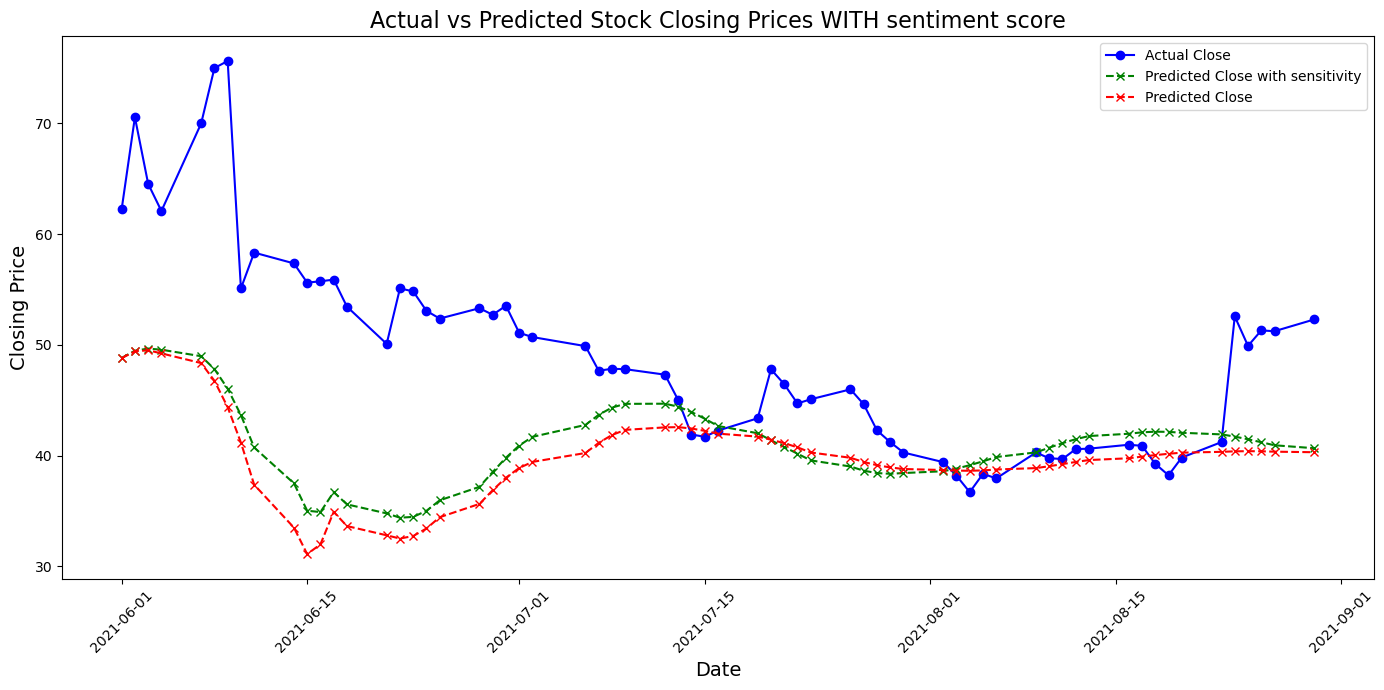

Mean Squared Error (MSE): 138.60004264410682
Root Mean Squared Error (RMSE): 11.772851933329784
Mean Absolute Error (MAE): 8.842781604621052


In [145]:
test(sensitivity_df1,predictions_with_actuals_df)

**Sensitivity 2: Change sentiment of 2021-05-13 to 2021-05-28 to all negative**

In [146]:
sensitivity_df2 = GME_Sentiment[['Date','Close','sentiment']].copy()
sensitivity_df2['sentiment'][90:102] = 3.0
sensitivity_df2[90:102]

/var/folders/xk/_r4sdmz94tdddjfh7p0wll_40000gn/T/ipykernel_87992/787584502.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sensitivity_df2['sentiment'][90:102] = 3.0


,Date,Close,sentiment
90,2021-05-13,41.125000,3.0
91,2021-05-14,39.980000,3.0
92,2021-05-17,45.150002,3.0
93,2021-05-18,45.167500,3.0
94,2021-05-19,42.207500,3.0
95,2021-05-20,42.622501,3.0
96,2021-05-21,44.197498,3.0
97,2021-05-24,45.002499,3.0
98,2021-05-25,52.357498,3.0
99,2021-05-26,60.639999,3.0


In [147]:
train(sensitivity_df2)

Epoch 1/100
3/3 [==============================] - 2s 12ms/step - loss: 0.2021
Epoch 2/100
3/3 [==============================] - 0s 11ms/step - loss: 0.0623
Epoch 3/100
3/3 [==============================] - 0s 12ms/step - loss: 0.0743
Epoch 4/100
3/3 [==============================] - 0s 12ms/step - loss: 0.0441
Epoch 5/100
3/3 [==============================] - 0s 11ms/step - loss: 0.0494
Epoch 6/100
3/3 [==============================] - 0s 11ms/step - loss: 0.0516
Epoch 7/100
3/3 [==============================] - 0s 11ms/step - loss: 0.0422
Epoch 8/100
3/3 [==============================] - 0s 11ms/step - loss: 0.0405
Epoch 9/100
3/3 [==============================] - 0s 11ms/step - loss: 0.0429
Epoch 10/100
3/3 [==============================] - 0s 11ms/step - loss: 0.0393
Epoch 11/100
3/3 [==============================] - 0s 12ms/step - loss: 0.0386
Epoch 12/100
3/3 [==============================] - 0s 11ms/step - loss: 0.0400
Epoch 13/100
3/3 [==============================]

1/1 [==============================] - 0s 7ms/step


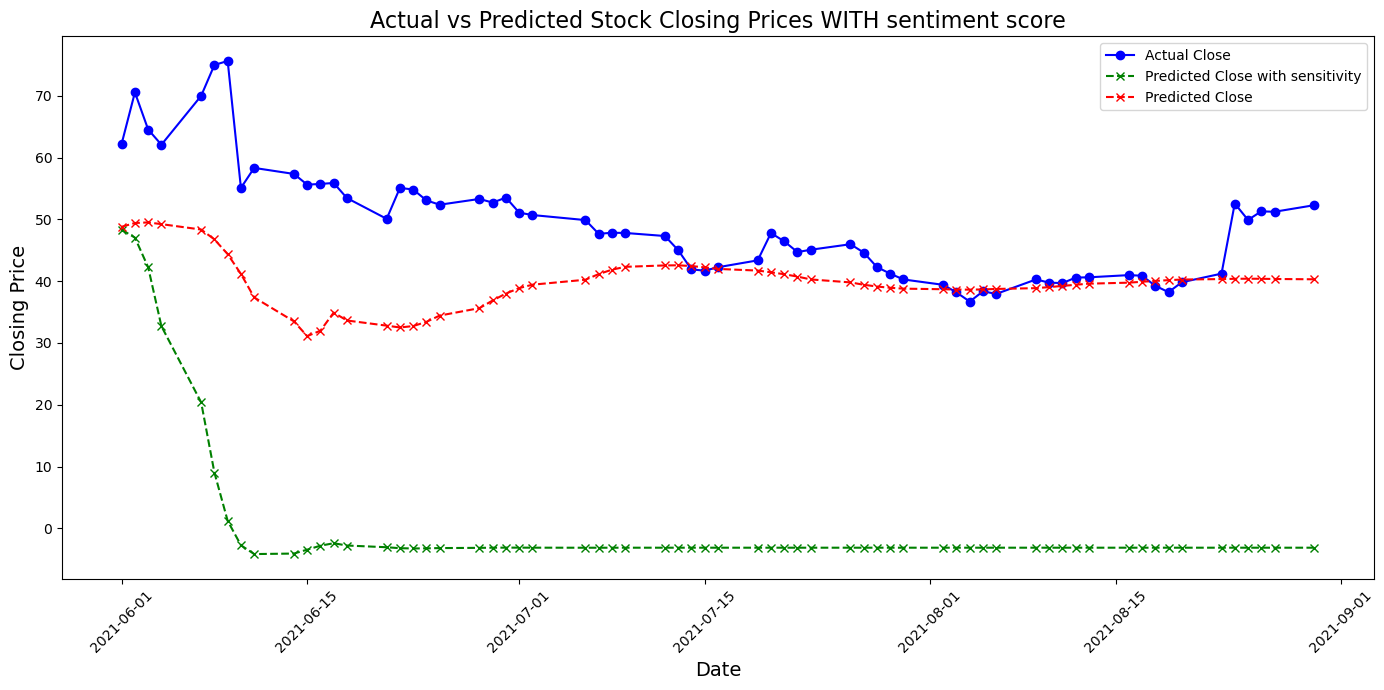

Mean Squared Error (MSE): 2471.6080251576486
Root Mean Squared Error (RMSE): 49.715269537212095
Mean Absolute Error (MAE): 48.74040385277536


In [148]:
test(sensitivity_df2,predictions_with_actuals_df)

**Sensitivity 3: Change sentiment of 2021-05-13 to 2021-05-27 to all positive and 2021-05-28 to negative**

In [149]:
sensitivity_df3 = GME_Sentiment[['Date','Close','sentiment']].copy()
sensitivity_df3['sentiment'][90:101] = 1.0
sensitivity_df3['sentiment'][101:] = 3.0
sensitivity_df3[101:]

/var/folders/xk/_r4sdmz94tdddjfh7p0wll_40000gn/T/ipykernel_87992/1297999263.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sensitivity_df3['sentiment'][90:101] = 1.0
/var/folders/xk/_r4sdmz94tdddjfh7p0wll_40000gn/T/ipykernel_87992/1297999263.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sensitivity_df3['sentiment'][101:] = 3.0


,Date,Close,sentiment
101,2021-05-28,55.5,3.0


In [150]:
train(sensitivity_df3)

Epoch 1/100
3/3 [==============================] - 2s 13ms/step - loss: 0.1739
Epoch 2/100
3/3 [==============================] - 0s 11ms/step - loss: 0.0566
Epoch 3/100
3/3 [==============================] - 0s 11ms/step - loss: 0.0482
Epoch 4/100
3/3 [==============================] - 0s 12ms/step - loss: 0.0312
Epoch 5/100
3/3 [==============================] - 0s 14ms/step - loss: 0.0302
Epoch 6/100
3/3 [==============================] - 0s 11ms/step - loss: 0.0348
Epoch 7/100
3/3 [==============================] - 0s 11ms/step - loss: 0.0279
Epoch 8/100
3/3 [==============================] - 0s 11ms/step - loss: 0.0247
Epoch 9/100
3/3 [==============================] - 0s 11ms/step - loss: 0.0275
Epoch 10/100
3/3 [==============================] - 0s 11ms/step - loss: 0.0252
Epoch 11/100
3/3 [==============================] - 0s 12ms/step - loss: 0.0238
Epoch 12/100
3/3 [==============================] - 0s 12ms/step - loss: 0.0250
Epoch 13/100
3/3 [==============================]

1/1 [==============================] - 0s 8ms/step


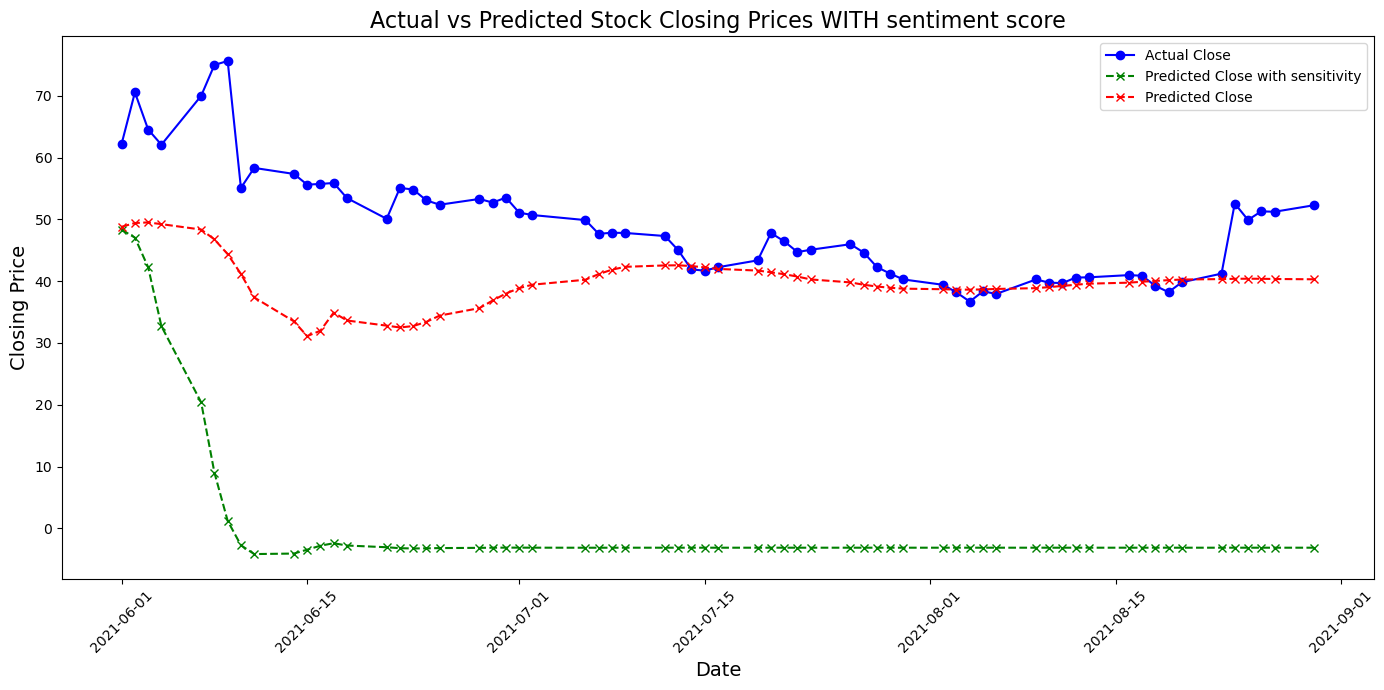

Mean Squared Error (MSE): 2471.6080251576486
Root Mean Squared Error (RMSE): 49.715269537212095
Mean Absolute Error (MAE): 48.74040385277536


In [151]:
test(sensitivity_df3,predictions_with_actuals_df)

**Sensitivity 4: Change sentiment of 2021-05-13 to 2021-05-27 to all negative and 2021-05-28 to positive**

In [152]:
sensitivity_df4 = GME_Sentiment[['Date','Close','sentiment']].copy()
sensitivity_df4['sentiment'][90:101] = 3.0
sensitivity_df4['sentiment'][101:] = 1.0
sensitivity_df4[101:]

/var/folders/xk/_r4sdmz94tdddjfh7p0wll_40000gn/T/ipykernel_87992/1048825567.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sensitivity_df4['sentiment'][90:101] = 3.0
/var/folders/xk/_r4sdmz94tdddjfh7p0wll_40000gn/T/ipykernel_87992/1048825567.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sensitivity_df4['sentiment'][101:] = 1.0


,Date,Close,sentiment
101,2021-05-28,55.5,1.0


In [153]:
train(sensitivity_df4)

Epoch 1/100
3/3 [==============================] - 2s 11ms/step - loss: 0.2145
Epoch 2/100
3/3 [==============================] - 0s 10ms/step - loss: 0.0783
Epoch 3/100
3/3 [==============================] - 0s 11ms/step - loss: 0.0615
Epoch 4/100
3/3 [==============================] - 0s 12ms/step - loss: 0.0492
Epoch 5/100
3/3 [==============================] - 0s 11ms/step - loss: 0.0436
Epoch 6/100
3/3 [==============================] - 0s 11ms/step - loss: 0.0499
Epoch 7/100
3/3 [==============================] - 0s 11ms/step - loss: 0.0434
Epoch 8/100
3/3 [==============================] - 0s 11ms/step - loss: 0.0385
Epoch 9/100
3/3 [==============================] - 0s 11ms/step - loss: 0.0418
Epoch 10/100
3/3 [==============================] - 0s 12ms/step - loss: 0.0408
Epoch 11/100
3/3 [==============================] - 0s 11ms/step - loss: 0.0383
Epoch 12/100
3/3 [==============================] - 0s 12ms/step - loss: 0.0391
Epoch 13/100
3/3 [==============================]

1/1 [==============================] - 0s 8ms/step


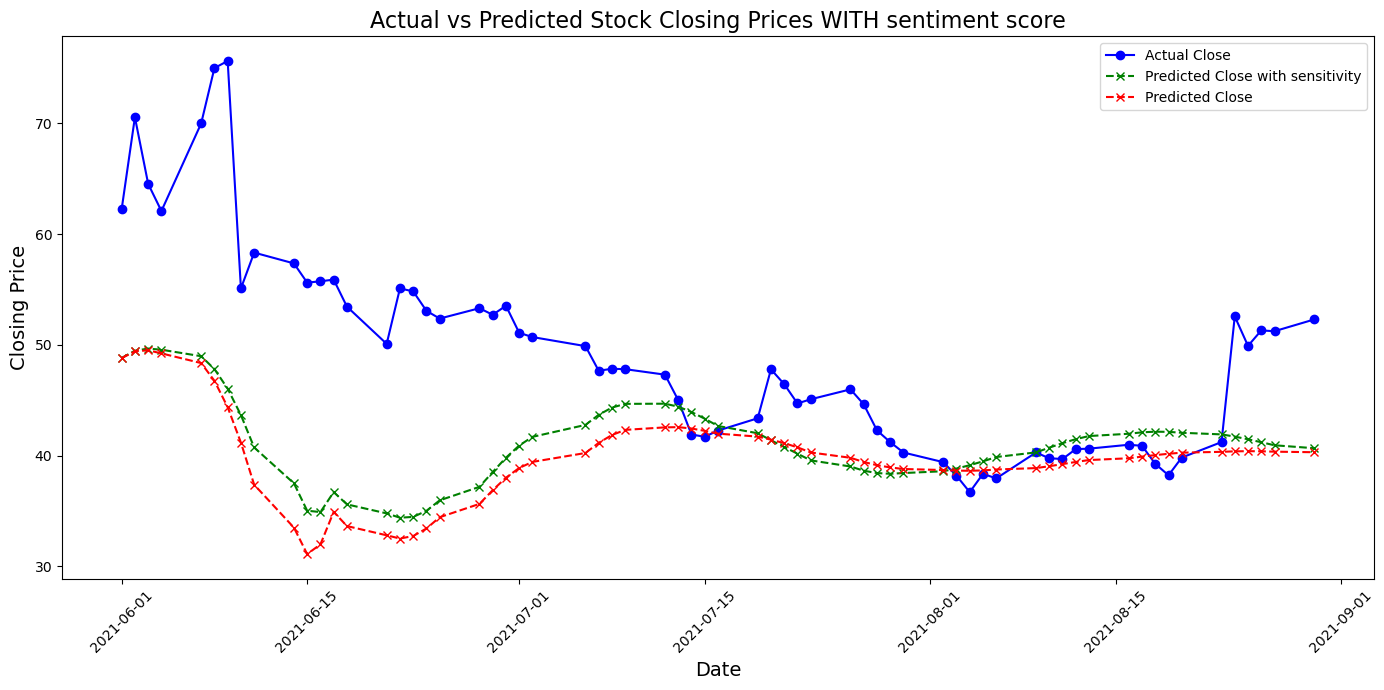

Mean Squared Error (MSE): 138.60004264410682
Root Mean Squared Error (RMSE): 11.772851933329784
Mean Absolute Error (MAE): 8.842781604621052


In [154]:
test(sensitivity_df4,predictions_with_actuals_df)

**Sensitivity 5: Change sentiment of 2021-05-1 to 2021-05-27 to all negative and 2021-05-28 to positive**

In [155]:
sensitivity_df5 = GME_Sentiment[['Date','Close','sentiment']].copy()
sensitivity_df5['sentiment'][0:50] = 3.0
sensitivity_df5[0:50]

/var/folders/xk/_r4sdmz94tdddjfh7p0wll_40000gn/T/ipykernel_87992/1802845956.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sensitivity_df5['sentiment'][0:50] = 3.0


,Date,Close,sentiment
0,2021-01-04,4.312500,3.0
1,2021-01-05,4.342500,3.0
2,2021-01-06,4.590000,3.0
3,2021-01-07,4.520000,3.0
4,2021-01-08,4.422500,3.0
5,2021-01-11,4.985000,3.0
6,2021-01-12,4.987500,3.0
7,2021-01-13,7.850000,3.0
8,2021-01-14,9.977500,3.0
9,2021-01-15,8.875000,3.0


In [156]:
train(sensitivity_df5)

Epoch 1/100
3/3 [==============================] - 2s 19ms/step - loss: 0.3010
Epoch 2/100
3/3 [==============================] - 0s 12ms/step - loss: 0.1179
Epoch 3/100
3/3 [==============================] - 0s 12ms/step - loss: 0.0935
Epoch 4/100
3/3 [==============================] - 0s 12ms/step - loss: 0.0794
Epoch 5/100
3/3 [==============================] - 0s 12ms/step - loss: 0.0668
Epoch 6/100
3/3 [==============================] - 0s 11ms/step - loss: 0.0778
Epoch 7/100
3/3 [==============================] - 0s 11ms/step - loss: 0.0700
Epoch 8/100
3/3 [==============================] - 0s 12ms/step - loss: 0.0611
Epoch 9/100
3/3 [==============================] - 0s 11ms/step - loss: 0.0650
Epoch 10/100
3/3 [==============================] - 0s 11ms/step - loss: 0.0647
Epoch 11/100
3/3 [==============================] - 0s 12ms/step - loss: 0.0609
Epoch 12/100
3/3 [==============================] - 0s 11ms/step - loss: 0.0613
Epoch 13/100
3/3 [==============================]

1/1 [==============================] - 0s 8ms/step


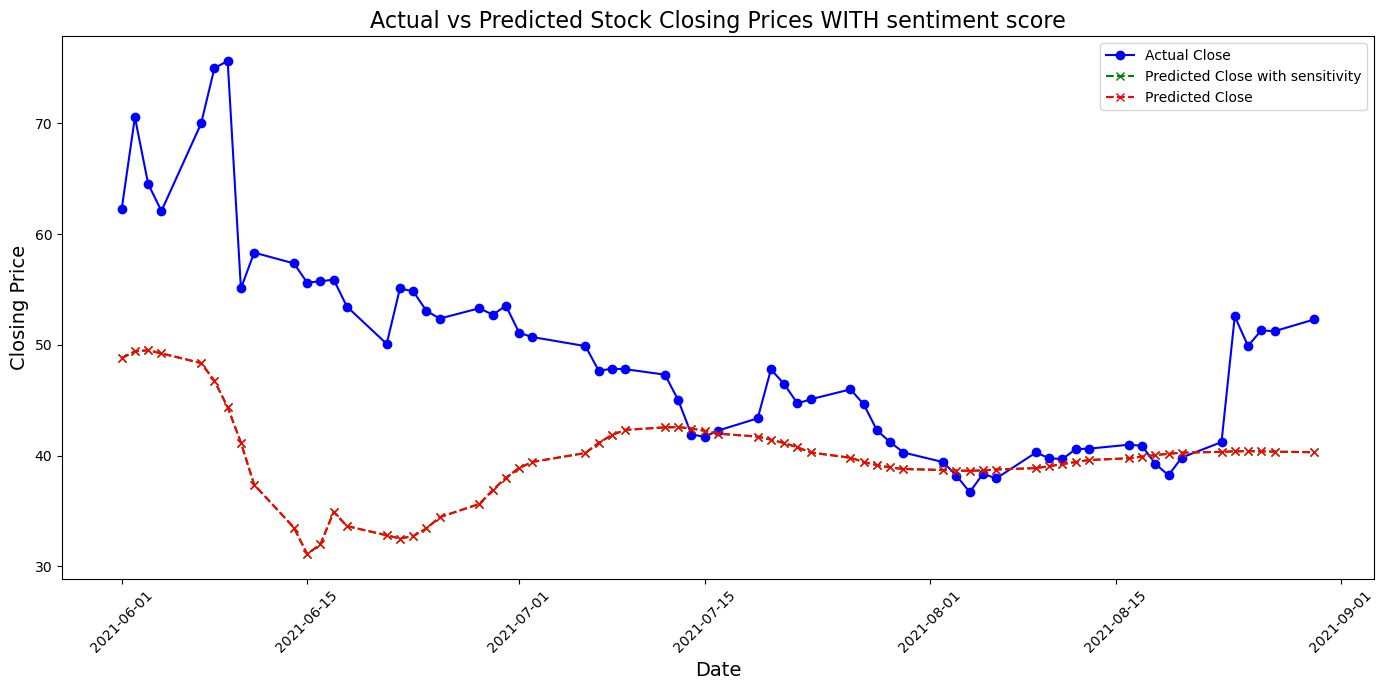

Mean Squared Error (MSE): 165.8012483058564
Root Mean Squared Error (RMSE): 12.876383355036321
Mean Absolute Error (MAE): 9.544308254941228


In [157]:
test(sensitivity_df5,predictions_with_actuals_df)